# About data_connector

This notebook pulls information from different sources of data (log, session) to connect student's data across types.
The end goal is a connection between student id and log files, survey data, and worksheet data.

In [1]:
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import matplotlib
import matplotlib.pyplot as plt
from utils_timeline_viz import find_student_log_file
#utils_read_parsing.py is where all our custorm functions live so we set an autoreload on it.
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing 
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 20, 7
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)

## Overview
We have log data, survey data, worksheet data and lots of metadata. We have to connect them all! First we must build the right metadata files.
Let's start by connecting log data files to session data, mapping each log data to a student and to a session using dates and times.

## Connecting log data to session data
We grab the parsing file reports and the session data

In [2]:
df_beers = get_latest_parsing_report('beers')
df_beers = df_beers[df_beers.studentid != 'student1']
df_beers.studentid = df_beers.studentid.astype(int)
df_caps = get_latest_parsing_report('capacitor')
df_caps.studentid = df_caps.studentid.astype(int)
df_sessions = get_session_data()

Captured beers parsing report that was parsed on 2017-11-24_16.04.04
Captured capacitor parsing report that was parsed on 2017-11-27_09.33.22


In [3]:
df_sessions

,session number,date,number of students from sign out sheet,start time,end time,wave,ran study,supported,keep
0,1,2017-1-13,5,13,15,1,Jon,Sarah,drop
1,2,2017-1-17,14,11,13,1,Jon,Sarah,keep
2,3,2017-1-17,18,15,17,1,Sarah,Jon,keep
3,4,2017-1-19,5,9,11,1,Sarah,Jon,keep
4,5,2017-1-19,18,13,15,1,Jon,Sarah,keep
5,6,2017-1-20,10,11,13,1,Sarah,Jon,keep
6,7,2017-1-20,18,15,17,1,Jon,Sarah,keep
7,8,2017-1-23,7,15,17,1,Sarah,Jon,keep
8,9,2017-1-27,12,13,15,1,Sarah,Jon,keep
9,10,2017-3-20,15,15,17,2,Sarah,Jon,keep


In [4]:
def get_session_times(df):
    times = {}
    for i,row in df.iterrows():
        day,start,end,session = row['date'],str(row['start time']),str(row['end time']),int(row['session number'])
        date = (day+'_'+start+".00.00",day+'_'+end+".00.00")
        times[session]=date
    return times
session_times = get_session_times(df_sessions)
print session_times

{1: ('2017-1-13_13.00.00', '2017-1-13_15.00.00'), 2: ('2017-1-17_11.00.00', '2017-1-17_13.00.00'), 3: ('2017-1-17_15.00.00', '2017-1-17_17.00.00'), 4: ('2017-1-19_9.00.00', '2017-1-19_11.00.00'), 5: ('2017-1-19_13.00.00', '2017-1-19_15.00.00'), 6: ('2017-1-20_11.00.00', '2017-1-20_13.00.00'), 7: ('2017-1-20_15.00.00', '2017-1-20_17.00.00'), 8: ('2017-1-23_15.00.00', '2017-1-23_17.00.00'), 9: ('2017-1-27_13.00.00', '2017-1-27_15.00.00'), 10: ('2017-3-20_15.00.00', '2017-3-20_17.00.00'), 11: ('2017-3-21_17.00.00', '2017-3-21_19.00.00'), 12: ('2017-3-22_11.00.00', '2017-3-22_13.00.00'), 13: ('2017-3-22_15.00.00', '2017-3-22_17.00.00'), 14: ('2017-3-23_13.00.00', '2017-3-23_15.00.00'), 15: ('2017-3-28_15.00.00', '2017-3-28_17.00.00')}


In [5]:
def convert_from_unix_time(t):
    ''' Take a unix time stamp in milliseconds and convert to date and time'''
    return datetime.datetime.fromtimestamp(int(t)/1000.0).strftime('%Y-%m-%d_%H.%M.%S')

def convert_to_unix_time(date):
    ''' Take a date and time amd make a unix time stamp'''
    return datetime.datetime.strptime(date, '%Y-%m-%d_%H.%M.%S')

def convert_from_unix_time_plot(t):
    ''' Take a unix time stamp in milliseconds and convert to date and time'''
    return datetime.datetime.fromtimestamp(int(t)/1000.0).strftime('%m-%d_%H')

def extrapolate_session(row):
    session = 'NA'
    date = row['date']
    timestamp = convert_to_unix_time(date)
    for session_number,period in session_times.iteritems():
        t1,t2 = convert_to_unix_time(period[0]),convert_to_unix_time(period[1])
        if timestamp > t1 and timestamp < t2:
            session = session_number   
    return session

df_beers['Session'] = df_beers.apply(extrapolate_session, axis=1)
df_caps['Session'] = df_caps.apply(extrapolate_session, axis=1)

In [6]:
def get_ids_per_session(df):
    ids_per_session = {s:[] for s in set(df['Session'])}
    for i,row in df.iterrows():
        sid,session = str(row['studentid']),row['Session']
        ids_per_session[session].append(sid)
    return ids_per_session

session_beers = get_ids_per_session(df_beers)
session_caps = get_ids_per_session(df_caps)

In [7]:
out =open('session_mega_id_writeout.txt','w')
out.write('\t'.join(['Session','Session time','Expected number (signout sheet)','sim','number of logs','ids']))
for session in sorted(session_times.keys()):
    if session != 'NA':
        expected = str(int(df_sessions[df_sessions['session number']==session]['number of students from sign out sheet']))
    else:
        expected = 'NA'
    period = str(session_times[session][0])+' - '+str(session_times[session][1])
    out.write('\n')
    out.write('\t'.join([str(session),period,expected,'beers',str(len(session_beers[session])), '\t'.join(sorted(session_beers[session]))]))
    out.write('\n')
    out.write('\t'.join(['','','','caps',str(len(session_caps[session])), '\t'.join(sorted(session_caps[session]))]))
    out.write('\n')
out.close()

In [8]:
df_beers.head()

,studentid,sim,date,first time stamp,time in PhET,number of user events,number of model events,number of table errors,number of records,number of gettingValues,number of restores,use table,use graph,use notepad,filename,Session
0,10105157,beers-law-lab,2017-03-22_11.41.17,1490208079592,740.21,2279,988,0,11,11,0,True,True,True,C:\Users\sperez8\Documents\Personal Content\La...,12
1,10127163,beers-law-lab,2017-01-27_13.26.59,1485552421644,971.09,3097,2114,0,23,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,9
2,10192168,beers-law-lab,2017-01-20_16.22.58,1484958181216,458.90,3443,1824,0,27,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,7
3,10232160,beers-law-lab,2017-01-20_15.24.45,1484954687669,811.30,4468,2253,0,8,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,7
4,10375163,beers-law-lab,2017-01-17_16.21.15,1484698878197,602.05,1476,817,0,15,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,3


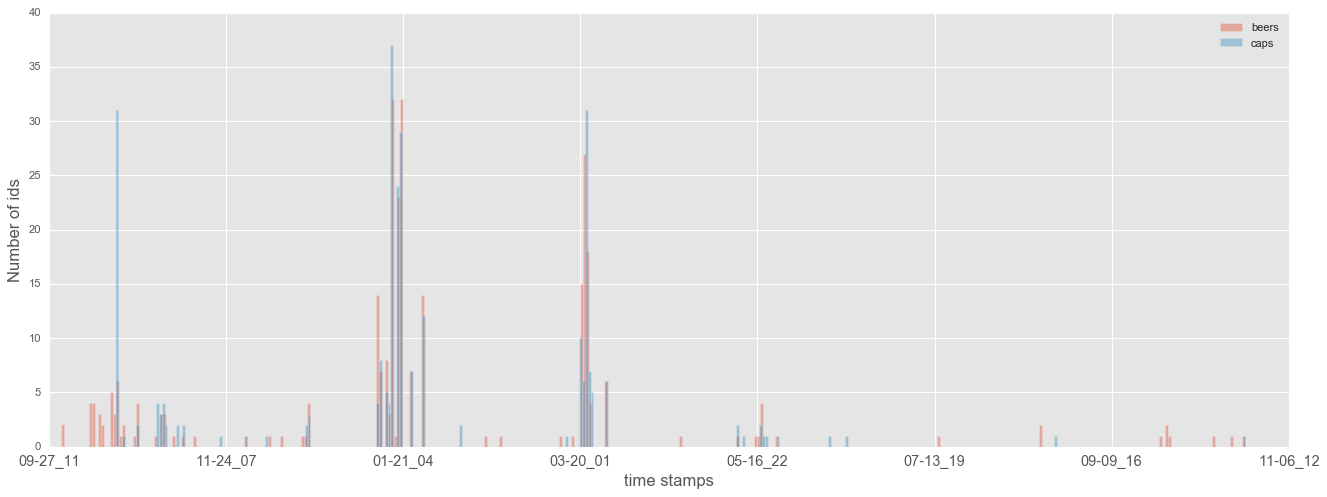

In [9]:
df_beers['first time stamp'].hist(bins=395,alpha=0.4,label='beers')
df_caps['first time stamp'].hist(bins=395,alpha=0.4,label='caps') #about 1 bin per day
# df_sessions['first time stamp'].hist(bins=50,alpha=0.6,label='caps')
ax = plt.subplot()
ax.legend();ax.set_xlabel('time stamps',fontsize=15);ax.set_ylabel('Number of ids',fontsize=15)
xticks = ax.get_xticks()
ax.set_xticklabels([convert_from_unix_time_plot(x) for x in xticks],fontsize=13)

In [10]:
#We can evaluate wither or not we should ignore these when we match their ids to all their log files with dates
# see the file created below "connector_id_to_log_files_and_session.txt"
print set(df_beers[df_beers['Session']=='NA']['studentid'])
print set(df_caps[df_caps['Session']=='NA']['studentid'])

set([12357888, 12344675, 11111111, 12345678, 12341234, 12345667, 12344564, 12344567, 78379161, 14444703, 12345567])
set([12456456, 78379161, 99999999, 12345678, 11111111])


## Find all logs per id
Now that we know what session each id is from, we can start documenting log file pairs to student ids. From the file "*session_mega_id_writeout.xlsx*" it's apparent that some student have several log files. We want to keep track of these to help with log data analysis later.
Ultimately we want a mega metadatafile with the following columns:
* student id
* session
* use in analysis - binary
* id in pre
* id in worksheet
* number of beers files
* number of caps files
* date beers 1
* date beers 2
* date beers 3
* date caps 1
* date caps 2
* date caps 3
* comments/issues

Some columns will be filled using information from the document "*running study and analytics thoughts.gdoc*"

In [11]:
#manual fixing
df_caps.loc[df_caps["studentid"] == 31607164 ,['studentid']] = 36107164
ids = list(set(df_beers.studentid).union(set(df_caps.studentid)))

meta_df = pd.DataFrame(index =ids, columns = ['session','use analysis','activity order','number of caps sessions','number of beers sessions','date caps 1','date caps 2','date caps 3','events caps 1','events caps 2','events caps 3','date beers 1','date beers 2','date beers 3','date beers 4','date beers 5','events beers 1','events beers 2','events beers 3','events beers 4','events beers 5','comments'])
meta_df = meta_df.fillna(0)
meta_df.index.name = 'studentid'

meta_df[['session']] = meta_df[['session']].astype(int)
meta_df[['use analysis']] = meta_df[['use analysis']].astype(bool)
meta_df[['activity order']] = meta_df[['activity order']].astype(str)
meta_df[['number of caps sessions']] = meta_df[['number of caps sessions']].astype(int)
meta_df[['number of beers sessions']] = meta_df[['number of beers sessions']].astype(int)
meta_df[['date caps 1']] = meta_df[['date caps 1']].astype(str)
meta_df[['date caps 2']] = meta_df[['date caps 2']].astype(str)
meta_df[['date caps 3']] = meta_df[['date caps 3']].astype(str)
meta_df[['events caps 1']] = meta_df[['events caps 1']].astype(int)
meta_df[['events caps 2']] = meta_df[['events caps 2']].astype(int)
meta_df[['events caps 3']] = meta_df[['events caps 3']].astype(int)
meta_df[['date beers 1']] = meta_df[['date beers 1']].astype(str)
meta_df[['date beers 2']] = meta_df[['date beers 2']].astype(str)
meta_df[['date beers 3']] = meta_df[['date beers 3']].astype(str)
meta_df[['date beers 4']] = meta_df[['date beers 4']].astype(str)
meta_df[['date beers 5']] = meta_df[['date beers 5']].astype(str)
meta_df[['events beers 1']] = meta_df[['events beers 1']].astype(int)
meta_df[['events beers 2']] = meta_df[['events beers 2']].astype(int)
meta_df[['events beers 3']] = meta_df[['events beers 3']].astype(int)
meta_df[['events beers 4']] = meta_df[['events beers 4']].astype(int)
meta_df[['events beers 5']] = meta_df[['events beers 5']].astype(int)
meta_df[['comments']] = meta_df[['comments']].astype(str)

In [12]:
for i,studentid in enumerate(ids):
#     print studentid
    session = 0
    b_logs = df_beers[df_beers["studentid"]==studentid]
    c_logs = df_caps[df_caps["studentid"]==studentid]
    c_logs = c_logs.sort_values('date')
    c_dates = c_logs['date'].values
    c_number_events = c_logs['number of user events'].values
    b_logs = b_logs.sort_values('date')
    b_dates = b_logs['date'].values
    b_number_events = b_logs['number of user events'].values
    b_sessions = b_logs['Session'].values
    c_sessions = c_logs['Session'].values
    error = ""
    order = np.nan
    n_beers = len(b_sessions)
    n_caps = len(c_sessions)
    b_date_1, b_events_1 = np.nan, 0
    b_date_2, b_events_2 = np.nan, 0
    b_date_3, b_events_3 = np.nan, 0
    b_date_4, b_events_4 = np.nan, 0
    b_date_5, b_events_5 = np.nan, 0
    c_date_1, c_events_1 = np.nan, 0
    c_date_2, c_events_2 = np.nan, 0
    c_date_3, c_events_3 = np.nan, 0
    if n_beers>=1:
        b_date_1, b_events_1 = b_logs['date'].values[0],b_logs['number of user events'].values[0]
    if n_caps>=1:
        c_date_1, c_events_1 = c_logs['date'].values[0],c_logs['number of user events'].values[0]

    #determine all logs belong to a session
    if 'NA' not in b_sessions and 'NA' not in c_sessions:
        #determine if there are at least 1 logs per sim
        if len(b_sessions)>=1 and len(c_sessions)>=1:
            #determine if all logs from same session
            if len(set(b_sessions).union(set(c_sessions))) == 1:
                use_analysis = True
                session = b_sessions[0]
                if n_caps >1 :
                    if n_caps == 2:
                        c_date_2, c_events_2 = c_logs['date'].values[1],c_logs['number of user events'].values[1]
                    elif n_caps == 3:
                        c_date_2, c_events_2 = c_logs['date'].values[1],c_logs['number of user events'].values[1]
                        c_date_3, c_events_3 = c_logs['date'].values[2],c_logs['number of user events'].values[2]
                    else:
                        error += "ERROR: more than 3 caps log files;"

                if n_beers >1 :
                    if n_beers == 2:
                        b_date_2, b_events_2 = b_logs['date'].values[1],b_logs['number of user events'].values[1]
                    elif n_beers == 3:
                        b_date_2, b_events_2 = b_logs['date'].values[1],b_logs['number of user events'].values[1]
                        b_date_3, b_events_3 = b_logs['date'].values[2],b_logs['number of user events'].values[2]
                    elif n_beers == 4:
                        b_date_2, b_events_2 = b_logs['date'].values[1],b_logs['number of user events'].values[1]
                        b_date_3, b_events_3 = b_logs['date'].values[2],b_logs['number of user events'].values[2]
                        b_date_4, b_events_4 = b_logs['date'].values[3],b_logs['number of user events'].values[3]
                    elif n_beers == 5: #there this one student who has 5 log files for beers...
                        b_date_2, b_events_2 = b_logs['date'].values[1],b_logs['number of user events'].values[1]
                        b_date_3, b_events_3 = b_logs['date'].values[2],b_logs['number of user events'].values[2]
                        b_date_4, b_events_4 = b_logs['date'].values[3],b_logs['number of user events'].values[3]
                        b_date_5, b_events_5 = b_logs['date'].values[4],b_logs['number of user events'].values[4]
                    else:
                        error += "ERROR: more than 5 beers log files;"
                
            else:
                error += "ERROR: student participated in more than 1 session?;"
                use_analysis = False
        else:
            error += "ERROR: student doesn't have logs in both sims;"
            use_analysis = False
    elif len(set(b_sessions).union(set(c_sessions))) > 1: #ie there are NAs and non NA sessions
        error += "ERROR: student has logs within and outside of sessions?;"
        use_analysis = False
    else: #all logs are outside of a session
        use_analysis = False
        
    #WE do some further filtering/fixing given what we know about different sessions and students
    if session in [1,12]: # sessions with missing data or where running the session ran into problems
        use_analysis = False
    if studentid == 11669161: #removed from study because student used their textbook
        use_analysis = False
        error += "ERROR: removed from study because student used their textbook, see running study docs;"

    #figure out in what order they did the sim activities
    if use_analysis:
        if max(b_dates) < min(c_dates):
            order = 'LC'
        elif max(c_dates) < min(b_dates):
            order = 'CL'
        else:
            use_analysis = False # can no longer use this student's log data
            error += "ERROR: student potentially has logs for sims at overlapping times"
    
    meta_df.set_value(studentid, 'session', session)
    meta_df.set_value(studentid, 'use analysis', use_analysis)
    meta_df.set_value(studentid, 'activity order', order)
    meta_df.set_value(studentid, 'number of caps sessions', n_caps)
    meta_df.set_value(studentid, 'number of beers sessions', n_beers)
    meta_df.set_value(studentid, 'date caps 1', str(c_date_1))
    meta_df.set_value(studentid, 'date caps 2', str(c_date_2))
    meta_df.set_value(studentid, 'date caps 3', str(c_date_3))
    meta_df.set_value(studentid, 'events caps 1', c_events_1)
    meta_df.set_value(studentid, 'events caps 2', c_events_2)
    meta_df.set_value(studentid, 'events caps 3', c_events_3)
    meta_df.set_value(studentid, 'date beers 1', str(b_date_1))
    meta_df.set_value(studentid, 'date beers 2', str(b_date_2))
    meta_df.set_value(studentid, 'date beers 3', str(b_date_3))
    meta_df.set_value(studentid, 'date beers 4', str(b_date_4))
    meta_df.set_value(studentid, 'date beers 5', str(b_date_5))
    meta_df.set_value(studentid, 'events beers 1', b_events_1)
    meta_df.set_value(studentid, 'events beers 2', b_events_2)
    meta_df.set_value(studentid, 'events beers 3', b_events_3)
    meta_df.set_value(studentid, 'events beers 4', b_events_4)
    meta_df.set_value(studentid, 'events beers 5', b_events_5)
    meta_df.set_value(studentid, 'comments', error)

meta_df.to_csv('connector_id_to_log_files_and_session.txt', sep='\t')

## Quick descriptive analysis of student logs
Keep in mind that one student (id: 23784336) is actually two students with collided ids. (It's been fixed in the xlsx file in the workspace data folder.

In [13]:
meta_df.groupby("use analysis").count()

,session,activity order,number of caps sessions,number of beers sessions,date caps 1,date caps 2,date caps 3,events caps 1,events caps 2,events caps 3,date beers 1,date beers 2,date beers 3,date beers 4,date beers 5,events beers 1,events beers 2,events beers 3,events beers 4,events beers 5,comments
use analysis,,,,,,,,,,,,,,,,,,,,,
False,30,0,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
True,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149


In [14]:
meta_df.groupby("activity order").count()

,session,use analysis,number of caps sessions,number of beers sessions,date caps 1,date caps 2,date caps 3,events caps 1,events caps 2,events caps 3,date beers 1,date beers 2,date beers 3,date beers 4,date beers 5,events beers 1,events beers 2,events beers 3,events beers 4,events beers 5,comments
activity order,,,,,,,,,,,,,,,,,,,,,
CL,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72
LC,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77


In [15]:
meta_df.groupby("session").count()

,use analysis,activity order,number of caps sessions,number of beers sessions,date caps 1,date caps 2,date caps 3,events caps 1,events caps 2,events caps 3,date beers 1,date beers 2,date beers 3,date beers 4,date beers 5,events beers 1,events beers 2,events beers 3,events beers 4,events beers 5,comments
session,,,,,,,,,,,,,,,,,,,,,
0,14,0,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
1,5,0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
3,17,16,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
4,5,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
5,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
6,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
7,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
8,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7


In [16]:
#check student with an error
meta_df[(meta_df["comments"]!="")]

,session,use analysis,activity order,number of caps sessions,number of beers sessions,date caps 1,date caps 2,date caps 3,events caps 1,events caps 2,events caps 3,date beers 1,date beers 2,date beers 3,date beers 4,date beers 5,events beers 1,events beers 2,events beers 3,events beers 4,events beers 5,comments
studentid,,,,,,,,,,,,,,,,,,,,,,
11669161,4,False,NaN,3,1,2017-01-19_09.27.40,2017-01-19_09.49.09,2017-01-19_09.49.18,1892,0,12,2017-01-19_10.23.33,nan,nan,nan,nan,3032,0,0,0,0,ERROR: removed from study because student used...
23784336,3,False,NaN,2,2,2017-01-17_15.23.14,2017-01-17_16.21.25,nan,1352,1543,0,2017-01-17_15.23.24,2017-01-17_16.21.22,nan,nan,nan,2976,1742,0,0,0,ERROR: student potentially has logs for sims a...
13493169,0,False,NaN,0,1,nan,nan,nan,0,0,0,2017-03-22_11.40.21,nan,nan,nan,nan,400,0,0,0,0,ERROR: student doesn't have logs in both sims;


# Connect to worksheet data

We load the ids for which we have log files

In [17]:
ids = set(get_students_to_analyze_log())

The function to load the actual worksheet data 

In [18]:
SIM_NAMES = {'beers':'ABSORBANCE','caps':'CAPACITORS'}
def get_worksheet_data_per_sim(sim):
    if sim == 'capacitor':
        sim = 'caps'
    #get primary metadata file for that sim
    primary_filepath = os.path.join(BIG_FOLDER,'coded worksheet data\\all_model_types_correctness_coding\\'+sim+'_coded_with_model-type.csv')
    primary_df = pd.read_csv(primary_filepath,sep=',')
    
    #get metadata file for extras worksheets
    extras_filepath = os.path.join(BIG_FOLDER,'coded worksheet data\\all_model_types_correctness_coding\extras_coded_with_model-type.csv')
    extras_df = pd.read_csv(extras_filepath,sep=',')
    extras_df = extras_df[extras_df['Topic']==SIM_NAMES[sim]]
    df = pd.concat([primary_df,extras_df])   
    df = df.reset_index(drop=True)
    return df

## beers

We load the metadata for worksheet data

In [19]:
%reload_ext utils_read_parsing
metadata = get_worksheet_metadata('beers')
metadata.head()

,Student ID,Topic,Type,other id,Session,Technical Flags,Comment,use analysis
0,10127163,ABSORBANCE,p,10127163,9,NaN,NaN,True
1,10127163,ABSORBANCE,m,10129163,9,NaN,NaN,True
2,10232160,ABSORBANCE,m,10232160,6-7,NaN,NaN,True
3,10232160,ABSORBANCE,p,10232160,6-7,NaN,factor = detector,True
4,10537160,ABSORBANCE,p,10375160,10,NaN,NaN,True


In [20]:
worksheets = get_worksheet_data_per_sim('beers')
worksheets.head()

,Student ID,Topic,Type,Factors,Model,Correct
0,10127163,ABSORBANCE,p,Concentration,qual,0.0
1,10127163,ABSORBANCE,p,Wavelength,qual,0.0
2,10127163,ABSORBANCE,p,Width,qual,0.0
3,10129163,ABSORBANCE,m,Concentration,qual,1.0
4,10129163,ABSORBANCE,m,Wavelength,qual,0.0


In [21]:
worksheets.groupby(["Type",'Factors','Model'])['Student ID'].nunique()

Type  Factors        Model
m     Concentration  ident    156
                     qual     156
                     quant    156
      Wavelength     ident    147
                     qual     147
                     quant    147
      Width          ident    153
                     qual     153
                     quant    153
p     Concentration  ident    137
                     qual     137
                     quant    137
      Wavelength     ident    136
                     qual     136
                     quant    136
      Width          ident    117
                     qual     117
                     quant    117
Name: Student ID, dtype: int64

In [22]:
ids_pre = set(worksheets[worksheets.Type=='p']['Student ID'])
ids_main = set(worksheets[worksheets.Type=='m']['Student ID'])

For all the ids for which we have log data (ids) we check if we have a pre and a main worksheet data entry. If not in the raw data, than the metadata file will have it corresponding id in it's "other id" column

In [23]:
from tabulate import tabulate
t =[['id with logs','absent from','in metadata other ids', 'other id']]
for i in ids:
    if   i in ids_pre and i in ids_main:
        pass
    elif i in ids_pre and i not in ids_main:
        t.append([i,'main', int(metadata[(metadata['Student ID']==i)&(metadata['Type']=='m')]['Student ID'])==i, int(metadata[(metadata['Student ID']==i)&(metadata['Type']=='m')]['other id'])])
    elif i not in ids_pre and i in ids_main:
        t.append([i,'pre', int(metadata[(metadata['Student ID']==i)&(metadata['Type']=='p')]['Student ID'])==i, int(metadata[(metadata['Student ID']==i)&(metadata['Type']=='p')]['other id'])])
    elif i not in ids_pre and i not in ids_main:
        t.append([i,'both', i in metadata['Student ID'], i in metadata['other id']])
t.sort(key=lambda x: x[1])
print tabulate(t)

------------  -----------  ---------------------  ---------
id with logs  absent from  in metadata other ids  other id
10561164      both         False                  False
10192168      both         False                  False
11997159      both         False                  False
10908162      main         True                   1090162
11929166      main         True                   119291166
19608154      main         True                   19605154
19989152      main         True                   19984152
15188167      main         True                   15199167
17448165      main         True                   17448105
10127163      main         True                   10129163
13624169      main         True                   13624
16136159      main         True                   16136157
15298166      pre          True                   5298166
11394167      pre          True                   11394167
15444164      pre          True                   15444164
10537160 

## caps

Now we do the same for caps as we did for beers

In [24]:
%reload_ext utils_read_parsing
metadata = get_worksheet_metadata('caps')
metadata.head()

,Student ID,Topic,Type,other id,Session,Technical Flags,Comment,use analysis
0,10127163,CAPACITORS,m,10127163,9,NaN,NaN,True
1,10127163,CAPACITORS,p,10127163,9,NaN,NaN,True
2,10232160,CAPACITORS,m,10232160,07-Jun,sp,NaN,True
3,10232160,CAPACITORS,p,10232160,07-Jun,NaN,NaN,True
4,17007153,CAPACITORS,m,1700953,9,sn,NaN,True


In [25]:
worksheets = get_worksheet_data_per_sim('caps')
worksheets.head()

,Student ID,Topic,Type,Factors,Model,Correct
0,10127163,CAPACITORS,m,Area,qual,1.0
1,10127163,CAPACITORS,m,Sep,qual,1.0
2,10127163,CAPACITORS,m,Voltage,qual,1.0
3,10127163,CAPACITORS,p,Area,qual,1.0
4,10127163,CAPACITORS,p,Sep,qual,1.0


In [26]:
worksheets.groupby(["Type",'Factors','Model'])['Student ID'].nunique()

Type  Factors  Model
m     Area     ident    151
               qual     151
               quant    151
      Sep      ident    153
               qual     153
               quant    153
      Voltage  ident    136
               qual     136
               quant    136
p     Area     ident    133
               qual     133
               quant    133
      Sep      ident    136
               qual     136
               quant    136
      Voltage  ident    146
               qual     146
               quant    146
Name: Student ID, dtype: int64

In [27]:
worksheets.groupby(['Student ID'])['Factors'].nunique()

Student ID
192168      3
561164      3
1700953     2
3981167     3
4055131     3
5055169     3
6618163     2
10127163    3
10232160    3
10375160    1
10375163    3
10420167    3
10708152    3
10866146    3
10908162    3
10970160    3
11095146    3
11200165    3
11277158    3
11326321    3
11384795    2
11394167    3
11612162    3
11669161    3
11777163    3
11887159    3
11892169    3
11929166    3
12017165    3
12238164    3
12263156    3
12302161    3
12329163    3
12406161    3
12665164    3
12707161    3
12816168    3
12818156    3
12907149    3
13122150    3
13134165    3
13139162    3
13140165    3
13193166    3
13228164    3
13407169    3
13497169    3
13578154    3
13624169    3
13654167    3
13660166    3
13726167    3
13870641    3
13945160    3
13981167    3
14002169    3
14055131    3
14088168    3
14201151    3
14201157    3
14261165    3
14293162    3
14302168    3
14805169    3
14828163    3
15026512    3
15055169    3
15072160    3
15160164    3
15188167    3
15298166 

In [28]:
ids_pre = set(worksheets[worksheets.Type=='p']['Student ID'])
ids_main = set(worksheets[worksheets.Type=='m']['Student ID'])

In [29]:
from tabulate import tabulate
t =[['id with logs','absent from','in metadata other ids', 'other id']]
for i in ids:
    if   i in ids_pre and i in ids_main:
        pass
    elif i in ids_pre and i not in ids_main:
        t.append([i,'main', int(metadata[(metadata['Student ID']==i)&(metadata['Type']=='m')]['Student ID'])==i, int(metadata[(metadata['Student ID']==i)&(metadata['Type']=='m')]['other id'])])
    elif i not in ids_pre and i in ids_main:
        t.append([i,'pre', int(metadata[(metadata['Student ID']==i)&(metadata['Type']=='p')]['Student ID'])==i, int(metadata[(metadata['Student ID']==i)&(metadata['Type']=='p')]['other id'])])
    elif i not in ids_pre and i not in ids_main:
        t.append([i,'both', i in list(metadata['Student ID']), i in list(metadata['other id'])])
t.sort(key=lambda x: x[1])
print tabulate(t)

------------  -----------  ---------------------  --------
id with logs  absent from  in metadata other ids  other id
19780165      both         True                   False
10561164      both         True                   False
10537160      both         True                   True
10192168      both         True                   False
36107164      both         True                   False
11997159      both         True                   False
23836160      main         True                   23826160
17007153      main         True                   1700953
17112137      main         True                   17112137
15444164      main         True                   15444169
17448165      main         True                   17448105
14201151      main         True                   14201157
90447168      main         True                   80447168
13407169      main         True                   13497169
18247165      main         True                   18247165
11394167      pre